In [1]:
import utils.data_import as data_import
import utils.ml_utils as ml_utils

import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm

np.random.seed(123)

/anaconda3/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/anaconda3/envs/ONE/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')
    
import matplotlib.pyplot as plt
%matplotlib inline

No cuda.


In [3]:
import settings

if settings.ORIG_DATA == 0:
    train_file = 'training.txt'
    train, valid = data_import.normalize_and_split(org_data_path, train_file, test_size=settings.test_size)
elif settings.ORIG_DATA == 1:
    train_file = settings.imdb_file
    train, valid = data_import.import_imbd(train_file, to=10000, test_size=settings.test_size)
elif settings.ORIG_DATA == 2:
    df = data_import.import_wikitext(settings.batch_size, window_size=settings.window_size, 
                                     lines=settings.lines, prob_cut=0.05, cut_factor=0.50)
    train, valid = data_import.create_splits(df, test_size=settings.test_size)
    
data_import.create_split_files('.', train, valid)

Original text length:  2,051,910 token sequence.
Generated text length: 274,835 tokens.
Writing files to ./data
Train and validation files written to disk.
Sizes: (340, 3) (60, 3)


In [4]:
train_df = pd.read_csv('data/train.csv')
statement_lengths = train_df['statement'].apply(lambda x: len(x.split()))
print(train_df['statement'][0])
print(train_df['tag'][0])
display(statement_lengths.describe())

= Valkyria Chronicles III = Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third
Valkyria Chronicles III = Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game


count    340.000000
mean      67.352941
std        2.810456
min       61.000000
25%       65.000000
50%       66.000000
75%       69.000000
max       71.000000
Name: statement, dtype: float64

In [5]:
valid.head()

,tag,statement,tag_id
340,"Her father , who was a musician in Sri Lanka ,...",". Her father , who was a musician in Sri Lanka...",340
341,of fourteen . After receiving her early educat...,age of fourteen . After receiving her early ed...,341
342,she had aspired to become an actress at a youn...,", she had aspired to become an actress at a yo...",342
343,crowned the winner of the Miss Universe Sri La...,was crowned the winner of the Miss Universe Sr...,343
344,"confidence "" . In 2006 , she appeared in a mus...",", confidence "" . In 2006 , she appeared in a m...",344


In [6]:
data_path = './data'

In [7]:
TEXT = data.Field(sequential=True, lower=True)
#LABEL = data.Field(sequential=True, use_vocab=True)
#SENTIMENT = data.Field(sequential=False, use_vocab=False)

In [8]:
datafields = [('tag', TEXT),
              ('statement', TEXT),
              ('tag_id', None)]

train, test = data.TabularDataset.splits(
    path=data_path,
    train='train.csv', validation='valid.csv',
    format='csv',
    skip_header=True,
    fields=datafields)

In [9]:
#TEXT.build_vocab(train, test, train_imdb, test_imdb, vectors='glove.6B.'+str(settings.emb_dim)+'d')
#TEXT.build_vocab(train, test, vectors='glove.6B.'+str(settings.emb_dim)+'d')
TEXT.build_vocab(train, test)
#LABEL.build_vocab(train, test, vectors='glove.6B.'+str(settings.emb_dim)+'d')
#SENTIMENT.build_vocab(train_imdb, test_imdb)

In [10]:
#n_classes = len(LABEL.vocab)
#print('Number of classes:', n_classes)
#n_sent = len(dict(SENTIMENT.vocab.freqs).keys())
#print('Number of sentiments:', n_sent)
#print((TEXT.vocab.itos))

In [11]:
print('len(trn):', len(train))
print('len(test):', len(test))
print()
print(TEXT.vocab.freqs.most_common(20))
print()
print(TEXT.vocab.itos[:10])
#print(vars(train[0]))
#print()
#print(LABEL.vocab.freqs.most_common(20))
#print(LABEL.vocab.itos[:10])
#print(LABEL.vocab.stoi)
#print(SENTIMENT.vocab.stoi)

len(trn): 340
len(test): 60

[('the', 3540), (',', 2518), ('.', 1905), ('<unk>', 1550), ('of', 1349), ('and', 1296), ('in', 1158), ('to', 1033), ('a', 945), ('=', 816), ('was', 692), ('"', 507), ('@-@', 500), ('for', 473), ('with', 437), ("'s", 412), (')', 313), ('(', 312), ('by', 309), ('as', 307)]

['<unk>', '<pad>', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a']


In [12]:
#print(TEXT.vocab.vectors.shape)
vocab_size = len(TEXT.vocab)
print('Vocab size:',vocab_size)
#TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

Vocab size: 4307


In [13]:
#trn, vld = train.split(0.7)
trn = train
vld = test
print('len(trn):', len(trn))
print('len(vld):', len(vld))
print('len(test):', len(test))

len(trn): 340
len(vld): 60
len(test): 60


In [14]:
train_iter, val_iter = data.BucketIterator.splits(
    datasets=(trn, vld),
    batch_sizes=(settings.batch_size, settings.batch_size),
    sort_key=lambda x: len(x.statement),
    sort_within_batch=False,
    repeat=False,
    shuffle=False,
    sort=False
)

In [15]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_fields):
        self.dl, self.x_field, self.y_fields = dl, x_field, y_fields
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_fields)
            #y = torch.cat([getattr(batch, feat).unsqueeze(1) 
            #               for feat in self.y_fields], dim=1).float()
            if cuda:
                X = X.cuda()
                y = y.cuda()
            yield (X, y)

In [16]:
train_dl = BatchGenerator(train_iter, 'statement', 'tag')
valid_dl = BatchGenerator(val_iter, 'statement', 'tag')

In [17]:
class simpleLSTM(nn.Module):
    def __init__(self, emb_dim, hidden_dim, n_layers=1, pretrained_vec=torch.zeros(0),
                 change_emb=True, dropout=0):
        
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        
        self.embedding.weight.requires_grad = change_emb
        
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, dropout=dropout)
        
        self.fc = nn.Linear(2*hidden_dim, len(TEXT.vocab))
        
        self.dropout = nn.Dropout(dropout)
        
        self.init_weights(pretrained_vec)
        
    def init_weights(self, pretrained_vec, initrange=0.1):
        
        if len(pretrained_vec) > 0:
            print('Loaded pretrained vectors.')
            self.embedding.weight.data.copy_(pretrained_vec)
        else:
            print('Not loaded pretrained vectors, uniform init in [-{}, {}].'.format(initrange, initrange))
            self.embedding.weight.data.uniform_(-initrange, initrange)
            
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, seq):
        
        #pdb.set_trace()
        # seq dims: [seq len, batch size]
        
        emb = self.embedding(seq)
        # emb dims: [seq len, batch size, emb dim]
        
        out, (hid, cel) = self.lstm(emb)
        
        # out dims: [seq len, batch size, hidden_dim]
        # hid dims: [2*n_layers, batch size, hidden_dim]
        # cel dims: [2*n_layers, batch size, hidden_dim]
        # out[-1,:,:hd] -> [batch size, hidden_dim]  (last time step hidden vector)
        # out[0,:,hd:] <- [batch size, hidden_dim]  (first time step hidden vector)
        # contatenation of last time period, whole batch, forward (first) chunck of hidden units
        #   and the first time period, whole batch, backward (last) chunck of hidden units
        #   (pytorch concatenates hidden units across dim #2 for bidirectional LSTM)
        #conc = torch.cat((out[-1,:,:self.hidden_dim], out[0,:,self.hidden_dim:]), dim=1)
        #conc = self.dropout(conc)
        
        output = self.dropout(out)
        
        output = self.fc(output)
        
        # sm dims: [batch size, n_classes]
        #sm = F.log_softmax(output, dim=-1)
        #return sm
    
        return output

In [18]:
model = simpleLSTM(emb_dim=settings.emb_dim,
                   hidden_dim=settings.hidden_dim,
                   n_layers=settings.num_layers,
                   #pretrained_vec=TEXT.vocab.vectors,
                   change_emb=True,
                   dropout=settings.dropout
                  )

Not loaded pretrained vectors, uniform init in [-0.1, 0.1].


In [19]:
if cuda:
    model = model.cuda()

In [20]:
print(model)

simpleLSTM(
  (embedding): Embedding(4307, 300)
  (lstm): LSTM(300, 1150, num_layers=3, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=2300, out_features=4307, bias=True)
  (dropout): Dropout(p=0.4)
)


In [21]:
missclass = []
missclass_next = []
losses = []

In [22]:
from tqdm import tqdm
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()

                preds = model(x)
                loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0)

                _, y_preds = torch.max(preds, dim=2)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)*y.size(1)
                
                miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals
            miss_next_wd_rate_tr = miss_next_wd / next_wd_tot

            epoch_loss = running_loss / len(trn)

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    preds = model(x)
                    loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                    val_loss += loss.item() * x.size(0)

                    _, y_preds = torch.max(preds, dim=2)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)*y.size(1)
                    
                    miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                    next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(vld)
            
            miss_next_wd_rate_val = miss_next_wd / next_wd_tot
            
            missclass_next.append((miss_next_wd_rate_tr, miss_next_wd_rate_val))
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Ppl: [{:6.2f}, {:6.2f}], Miss: [{:.2%}, {:.2%}], [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          math.exp(epoch_loss), math.exp(val_loss), 
                          missclass_tr, missclass_te,
                          miss_next_wd_rate_tr, miss_next_wd_rate_val))
            sys.stdout.flush()

            print('Saving weights file...', end=' ', flush=True)
            torch.save(model, 'model_weights.pt')
            print('Done.', flush=True)
            #to load: model = torch.load('model_weights.pt')
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [23]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Valid 1/10: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]

Epoch: 1/10, Loss: [18.1002, 9.6992], Ppl: [72578770.21, 16304.52], Miss: [96.66%, 99.84%], [95.59%, 100.00%]
Saving weights file... 


/anaconda3/envs/ONE/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type simpleLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Done.


Train 2/10:  40%|████      | 2/5 [01:21<02:02, 40.70s/it]

Stopping with latest weights.


In [43]:
x, y = next(iter(valid_dl))
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=2)
ml_utils.calc_miss_next_wds(y, y_preds)

58

In [48]:
print(y.shape)
y[:,2]

torch.Size([61, 60])
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60


58

In [45]:
y_preds[:,2]

tensor([ 83, 358,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   7,   5,   7,
          6,   6,   2,   2,   7,   2,   2,   2,   2,   2,   2,   7,   2,   2,
          2,   2,   2,   7,   2])

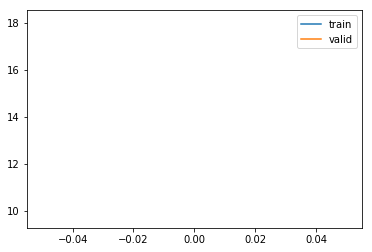

In [31]:
plt.plot(losses)
plt.legend(['train', 'valid'])

In [ ]:
plt.plot(missclass)
plt.legend(['train', 'valid'])

In [ ]:
plt.plot(missclass_next)
plt.legend(['train', 'valid'])